## Instalacón de paquetes

In [ ]:
!pip install ssl pillow matplotlib

## Carga de Libreria
---

In [1]:
# Load and preprocess images
import os
from PIL import Image

import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from elasticsearch import Elasticsearch
import ssl

from dotenv import load_dotenv
load_dotenv('../.env')

c:\Users\admin\OneDrive - Bittek Soluciones Tecnológicas\PROYECTOS\py11\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


True

## Conexión con Elasticsearch 
Crear una instancia del cliente de Elasticsearch utilizando una conexión segura y autenticación por clave API

In [9]:
cloud = False

if cloud:
    client = Elasticsearch(
    cloud_id=os.getenv("ELASTIC_CLOUD_ID"),
    basic_auth=("elastic", os.getenv("ELASTIC_PASSWORD")),
)
else:
  
  client = Elasticsearch(
    "https://localhost:9200/",
    api_key=os.getenv("ELASTIC_API_KEY"),
    ssl_context=ssl.create_default_context(cafile=os.getenv("ELASTIC_CERTIFICATE_DIR")),
  )
# Successful response!
client.info()

ObjectApiResponse({'name': 'instance-0000000001', 'cluster_name': '6245dd37d2934813bc1c46b937dd30d5', 'cluster_uuid': '61aAGaZITvaeXGEEdo1Ilg', 'version': {'number': '8.13.4', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'da95df118650b55a500dcc181889ac35c6d8da7c', 'build_date': '2024-05-06T22:04:45.107454559Z', 'build_snapshot': False, 'lucene_version': '9.10.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

Procedemos a crear el indice. En caso de que exista lo eliminamos y lo volvemos a crear. Definimos dos campos, uno para el texto que guardará el nombre de la imagen y otro para la imagen.

In [11]:
if client.indices.exists(index="image_index") == True:
    client.indices.delete(index="image_index")

index_name = "image_index"
mapping = {
    "mappings": {
        "properties": {
            "image_id": {"type": "keyword"},
            "image_vector": {
                "type": "dense_vector",
                "dims": 512,
            },
        }
    }
}
client.indices.create(index=index_name, body=mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'image_index'})

# Modelo clip-ViT

El modelo `SentenceTransformer("clip-ViT-B-32")` es una variante de los modelos SentenceTransformer que combina la arquitectura CLIP (Contrastive Language-Image Pre-Training) con la estructura de Transformer ViT-B-32 (Vision Transformer). Este modelo está diseñado para manejar tareas de procesamiento de texto e imágenes, permitiendo la generación de representaciones vectoriales (embeddings) de alta calidad tanto para textos como para imágenes.

## Características principales:

- **CLIP (Contrastive Language-Image Pre-Training)**: CLIP es un modelo desarrollado por OpenAI que se entrena en una gran cantidad de pares de datos de imágenes y textos. Esto le permite aprender a asociar textos con imágenes de manera efectiva, logrando un rendimiento impresionante en tareas de visión y lenguaje.
- **ViT-B-32 (Vision Transformer)**: ViT es una arquitectura de Transformer adaptada para la visión por computadora. La variante B-32 se refiere a un modelo base con un tamaño de parches de 32x32 píxeles. Este enfoque permite que el modelo procese imágenes de una manera similar a cómo los Transformers procesan secuencias de texto.
- **SentenceTransformer**: Los modelos SentenceTransformer están diseñados para producir embeddings de alta calidad para sentencias, párrafos y ahora también imágenes. Estos embeddings pueden ser utilizados en una variedad de tareas de procesamiento del lenguaje natural y visión por computadora, como búsqueda semántica, clustering, clasificación, entre otras.

Este modelo es especialmente útil en escenarios donde se necesita integrar y relacionar información visual y textual, proporcionando una herramienta poderosa para el.

En el siguiente apartado, crearemos los embeddings de cada imagen y los almacenaremos en el indice de elasticseacrh.


In [12]:
model = SentenceTransformer("clip-ViT-B-32")

# Index images
image_folder = 'data/'  # Update with your image folder path
for img_name in os.listdir(image_folder):
    features = model.encode(Image.open("data/"+img_name))
    document = {
        "image_id": img_name,
        "image_vector": features
    }
    client.index(index=index_name, body=document)

Una vez almacenada toda la información, procedemos a realizar la búsqueda de imágenes similares a una imagen de referencia. Para ello, utilizamos la función search() de la API de Elasticsearch, que nos permite buscar documentos similares a un documento de referencia. En este caso, buscamos imágenes similares a un prompt de texto. COmo el modelo clip es capaz de asociar la relación de un texto de entrafda con una imagen, vamos a tratar de buscar un gato y obtendremos las k imagenes que maximicen la similitud del coseno.

In [13]:
# Step 5: Text-to-Image search using CLIP
text_query = "a photo of a cat"
text_features = model.encode(text_query)

In [14]:
query = {
        'script_score' : {
            'query'  : { 'match_all' : {} },
            'script' : {
                'source' : "cosineSimilarity(params.image_vector, 'image_vector') + 1.0",
                'params' : { 'image_vector' : text_features }
            }
        }
    }

result = client.search(index = 'image_index', query = query, size = 2)

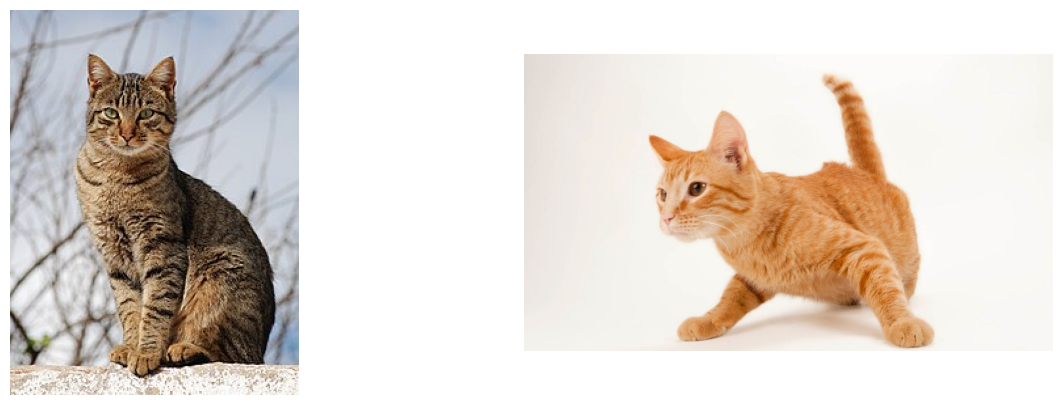

In [15]:
# Step 6: Display the most similar images
results = []
for i in range(len(result.body['hits']['hits'])):
    results.append(result.body['hits']['hits'][i]['_source']['image_id'])
    
def display_images(results):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(results):
        img_path = os.path.join(image_folder, idx)
        img = Image.open(img_path)
        plt.subplot(1, len(results), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_images(results)

Como se puede observar, el resultado obtenido ha sido el esperado. Hemos buscado por gatos y hemos obtenido imágenes de gatos. En este caso, hemos obtenido dos imágenes de gatos, pero podemos modificar el tamaño de la variable size en la función client.search para obtener más o menos imágenes.